DPsim
--------------------

As a first simple, test we will simulate a small static network. The network consists of 4 nodes and 4 elements:

| Component | Type            | Python Class                              | Node A | Node B | Paramter |
| :---------| :----           | :---------------------------------------- | :----- | :----- | :------- |
| vs       | Voltage Source  | `dpsimpy.emt.ph1.VoltageSource`       | 1      | GND    | 10 kV          |
| r1       | Line Resistance | `dpsimpy.emt.ph1.Resistor`            | 1      | 2      | 1 Ohm       |
| l1       | Line Inductance | `dpsimpy.emt.ph1.Inductor`            | 2      | 3      | 0.02 Henry  |
| rload    | Load Resistance | `dpsimpy.emt.ph1.Resistor`            | 3      | GND    | 10 Ohm       |

In [ ]:
import villas.dataprocessing.readtools as rt
import villas.dataprocessing.plottools as pt
from villas.dataprocessing.timeseries import TimeSeries as ts
import math
import dpsimpy

In [20]:
# DPsim DP simulation
name = 'VILLAS_test'

# Nodes
gnd = dpsimpy.dp.SimNode.gnd
n1 =  dpsimpy.dp.SimNode('n1')
n2 =  dpsimpy.dp.SimNode('n2')
n3 =  dpsimpy.dp.SimNode('n3')
n4 =  dpsimpy.dp.SimNode('n4')

# initialize node voltages as in simulunk
n2.set_initial_voltage(complex(0,0))
n3.set_initial_voltage(complex(0,0))

# Components
vs = dpsimpy.dp.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(10000, 0) * math.sqrt(2))
r1 = dpsimpy.dp.ph1.Resistor('r1')
r1.set_parameters(R=1)
l1 = dpsimpy.dp.ph1.Inductor('l1')
l1.set_parameters(L=0.02)

rload = dpsimpy.dp.ph1.Resistor('rload')
rload.set_parameters(R=10)
rload2 = dpsimpy.dp.ph1.Resistor('rload')
rload2.set_parameters(R=10)

sw = dpsimpy.dp.ph1.Switch('StepLoad', dpsimpy.LogLevel.debug)
sw.set_parameters(1e9, 0.01, False)
sw.connect([gnd, n4])
sw.open()

vs.connect([gnd, n1])
r1.connect([n1, n2])
l1.connect([n2, n3])
rload.connect([n3, gnd])
rload2.connect([n3, n4])

system = dpsimpy.SystemTopology(50, [gnd, n1, n2, n3, n4], [vs, r1, l1, rload, rload2, sw])

logger = dpsimpy.Logger(name)

In [21]:
name = 'VILLAS_test'

dpsimpy.Logger.set_log_dir("logs/" + name)

logger = dpsimpy.Logger(name)

for i in range(1, len(system.nodes)):
    logger.log_attribute("n" + str(i) + ".v", "v", system.nodes[i])
    
logger.log_attribute('r1.i_intf', 'i_intf', r1);
#logger.log_attribute('l1.i_intf', 'i_intf', l1);

sim = dpsimpy.Simulation(name)
sim.set_domain(dpsimpy.Domain.DP)
sim.set_system(system)
sim.set_time_step(0.0005)
sim.set_final_time(0.5)

# Events
sw_on = dpsimpy.event.SwitchEvent(0.1, sw, True)
sim.add_event(sw_on)

sw_off = dpsimpy.event.SwitchEvent(0.2, sw, False)
sim.add_event(sw_off)

sim.add_logger(logger)
print(sim)
sim.run()

1.000000e-01: Handle event time


[15:47:56.206019 MnaSolverFactory info] creating KLUAdapter solver implementation


2.000000e-01: Handle event time


In [22]:
# read DPsim DP results
work_dir = "logs/" + name + "/"
log_name = 'VILLAS_test'
print(work_dir + log_name + '.csv')
ts_dpsim_dp = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')



logs/VILLAS_test/VILLAS_test.csv
column number: 5
results length: 1001
real column names: []
complex column names: ['n1.v', 'n2.v', 'n3.v', 'n4.v', 'r1.i_intf']


In [23]:
# convert to emt
ts_dpsim_dp_emt = ts.frequency_shift_list(ts_dpsim_dp, 50)

# 3Ph, RMS to 1Ph 
for name, ts in ts_dpsim_dp_emt.items():
    ts.values = ts.values * math.sqrt(2)/2
    #print(ts.values)

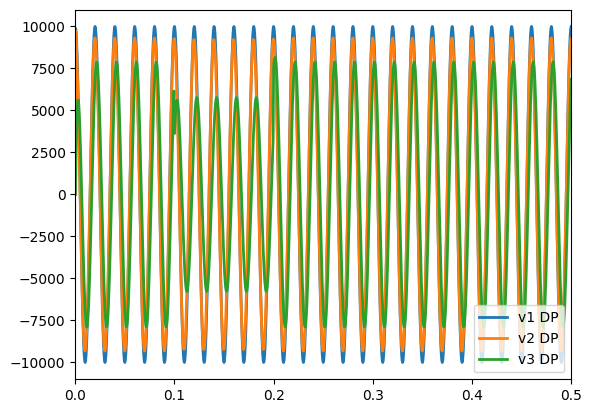

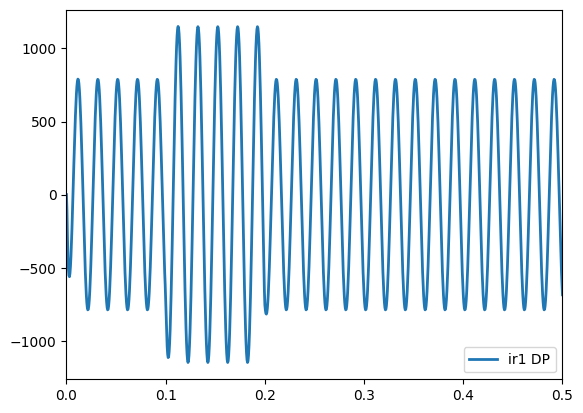

In [24]:
pt.set_timeseries_labels(ts_dpsim_dp_emt['n1.v_shift'], 'v1 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['n2.v_shift'], 'v2 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['n3.v_shift'], 'v3 DP')
#pt.set_timeseries_labels(ts_dpsim_dp_emt['n3.v_shift'], 'v3 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['r1.i_intf_shift'], 'ir1 DP')
#pt.set_timeseries_labels(ts_dpsim_dp_emt['l1.i_intf_shift'], 'il1  DP')
pt.plot_timeseries(1, ts_dpsim_dp_emt['n1.v_shift'])
pt.plot_timeseries(1, ts_dpsim_dp_emt['n2.v_shift'])
pt.plot_timeseries(1, ts_dpsim_dp_emt['n3.v_shift'])
#pt.plot_timeseries(1, ts_dpsim_dp_emt['n3.v_shift'])
pt.plot_timeseries(2, ts_dpsim_dp_emt['r1.i_intf_shift'])
#pt.plot_timeseries(2, ts_dpsim_dp_emt['l1.i_intf_shift'])